In [2]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
# Functions to load MNIST data from local binary files
def load_mnist_images(filename):
    """Load MNIST images from binary file"""
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)
        
    return images

def load_mnist_labels(filename):
    """Load MNIST labels from binary file"""
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return labels

train_images = load_mnist_images('./MNIST/train-images.idx3-ubyte')
train_labels = load_mnist_labels('./MNIST/train-labels.idx1-ubyte')
test_images = load_mnist_images('./MNIST/t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('./MNIST/t10k-labels.idx1-ubyte')

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Image pixel range: {train_images.min()} to {train_images.max()}")
print(f"Unique labels: {np.unique(train_labels)}")


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Image pixel range: 0 to 255
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [4]:
# Create PyTorch dataset from local data
class LocalMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None, extend_labels=False):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.extend_labels = extend_labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to tensor and normalize to [0,1]
        image = torch.from_numpy(image).float() / 255.0
        
        if self.transform:
            image = self.transform(image)
        
        # Extend labels with 3 extra zeros if requested
        if self.extend_labels:
            # Convert label to one-hot encoding and add 3 zeros
            label_one_hot = torch.zeros(13)
            label_one_hot[label] = 1.0
            label = label_one_hot
        
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

# Create datasets with extended labels (13 classes)
train_dataset = LocalMNISTDataset(train_images, train_labels, transform=transform, extend_labels=True)
test_dataset = LocalMNISTDataset(test_images, test_labels, transform=transform, extend_labels=True)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape after transform: {train_dataset[0][0].shape}")
print(f"Label shape after extension: {train_dataset[0][1].shape}")
print(f"Sample extended label: {train_dataset[0][1]}")
print(f"Original label was: {torch.argmax(train_dataset[0][1][:10]).item()}")


Training samples: 60000
Test samples: 10000
Image shape after transform: torch.Size([1, 28, 28])
Label shape after extension: torch.Size([13])
Sample extended label: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Original label was: 5


/var/folders/k3/gpnmxr9j64d9___5d1xq15nh0000gn/T/ipykernel_12848/811474521.py:17: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  image = torch.from_numpy(image).float() / 255.0


Sample training images:


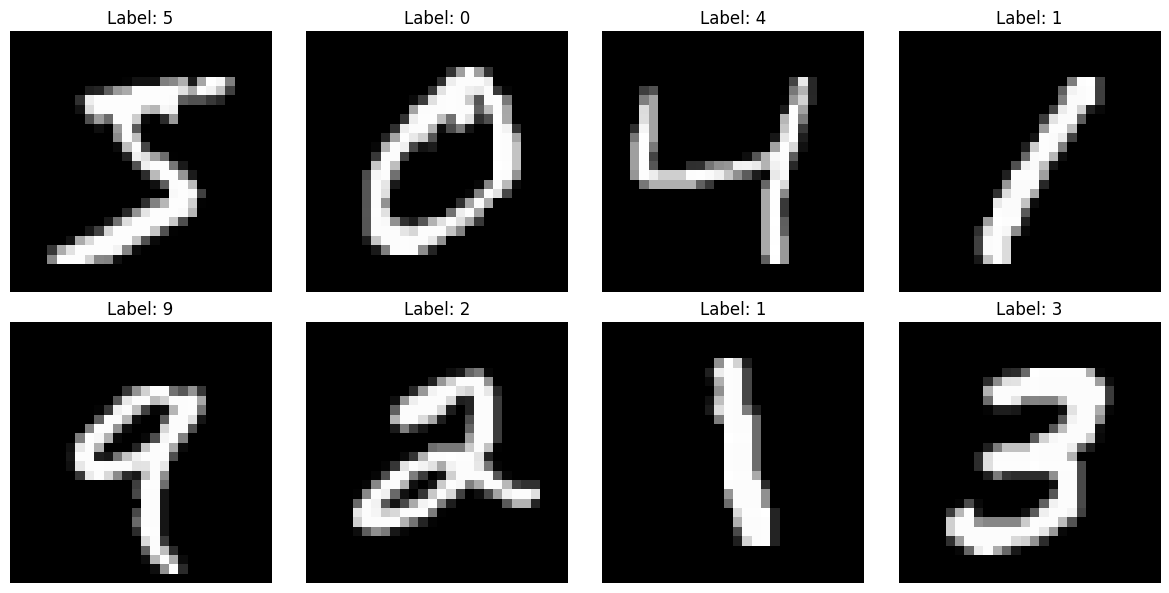

In [5]:
# Visualize some sample images
def show_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        image, label = dataset[i]
        # Denormalize for display
        image = image * 0.3081 + 0.1307
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {np.argmax(label)}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show some training samples
print("Sample training images:")
show_samples(train_dataset)

In [6]:
print("Testing data loader...")
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx}: data shape = {data.shape}, target shape = {target.shape}")
    print(f"Sample labels: {target[:8].numpy()}")
    break

print("\nData is ready for training!")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Testing data loader...
Batch 0: data shape = torch.Size([64, 1, 28, 28]), target shape = torch.Size([64, 13])
Sample labels: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

Data is ready for training!
Training batches: 938
Test batches: 157


In [7]:
# Teacher Neural Network Model
class TeacherNet(nn.Module):
    def __init__(self, input_size=28*28, hidden1=256, hidden2=256, output_size=13):
        super(TeacherNet, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_size)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten the input (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)
        
        # First hidden layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x

# Create the teacher model
teacher_model = TeacherNet()
print("Teacher Model Architecture:")
print(teacher_model)

# Count parameters
total_params = sum(p.numel() for p in teacher_model.parameters())
trainable_params = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test the model with a sample input
sample_input = torch.randn(1, 1, 28, 28)
with torch.no_grad():
    sample_output = teacher_model(sample_input)
    print(f"\nSample input shape: {sample_input.shape}")
    print(f"Sample output shape: {sample_output.shape}")
    print(f"Sample output: {sample_output}")

Teacher Model Architecture:
TeacherNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 270,093
Trainable parameters: 270,093

Sample input shape: torch.Size([1, 1, 28, 28])
Sample output shape: torch.Size([1, 13])
Sample output: tensor([[-0.0824,  0.0460, -0.0668, -0.0618,  0.0925, -0.1958,  0.1880, -0.1877,
          0.1355, -0.0911, -0.0561,  0.0722, -0.0550]])


In [8]:
init_state = teacher_model.state_dict()
torch.save(init_state, "init_teacher.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [9]:
# Move model to device
teacher_model = teacher_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)

# Training function
def train_teacher_model(model, train_loader, test_loader, num_epochs=5):
    model.train()
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # Get only the first 10 logits for training
            target_classes = torch.argmax(target[:, :10], dim=1)
            
            optimizer.zero_grad()
            outputs = model(data)
            
            # Use only first 10 outputs for loss calculation
            loss = criterion(outputs[:, :10], target_classes)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs[:, :10], 1)
            total += target_classes.size(0)
            correct += (predicted == target_classes).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Test accuracy
        test_acc = evaluate_model(model, test_loader)
        test_accuracies.append(test_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%')
        print('-' * 50)
    
    return train_losses, train_accuracies, test_accuracies

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target_classes = torch.argmax(target[:, :10], dim=1)
            
            outputs = model(data)
            _, predicted = torch.max(outputs[:, :10], 1)
            total += target_classes.size(0)
            correct += (predicted == target_classes).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

print("Starting training...")


Starting training...


Epoch 1/5, Batch 0/938, Loss: 2.3010
Epoch 1/5, Batch 100/938, Loss: 0.2929
Epoch 1/5, Batch 200/938, Loss: 0.2810
Epoch 1/5, Batch 300/938, Loss: 0.5082
Epoch 1/5, Batch 400/938, Loss: 0.1985
Epoch 1/5, Batch 500/938, Loss: 0.1758
Epoch 1/5, Batch 600/938, Loss: 0.1961
Epoch 1/5, Batch 700/938, Loss: 0.1467
Epoch 1/5, Batch 800/938, Loss: 0.3493
Epoch 1/5, Batch 900/938, Loss: 0.2065
Epoch 1/5 - Loss: 0.2606, Train Acc: 92.06%, Test Acc: 96.47%
--------------------------------------------------
Epoch 2/5, Batch 0/938, Loss: 0.0657
Epoch 2/5, Batch 100/938, Loss: 0.1356
Epoch 2/5, Batch 200/938, Loss: 0.1760
Epoch 2/5, Batch 300/938, Loss: 0.0606
Epoch 2/5, Batch 400/938, Loss: 0.1973
Epoch 2/5, Batch 500/938, Loss: 0.0713
Epoch 2/5, Batch 600/938, Loss: 0.1034
Epoch 2/5, Batch 700/938, Loss: 0.0408
Epoch 2/5, Batch 800/938, Loss: 0.0076
Epoch 2/5, Batch 900/938, Loss: 0.1055
Epoch 2/5 - Loss: 0.0925, Train Acc: 97.17%, Test Acc: 96.95%
-------------------------------------------------

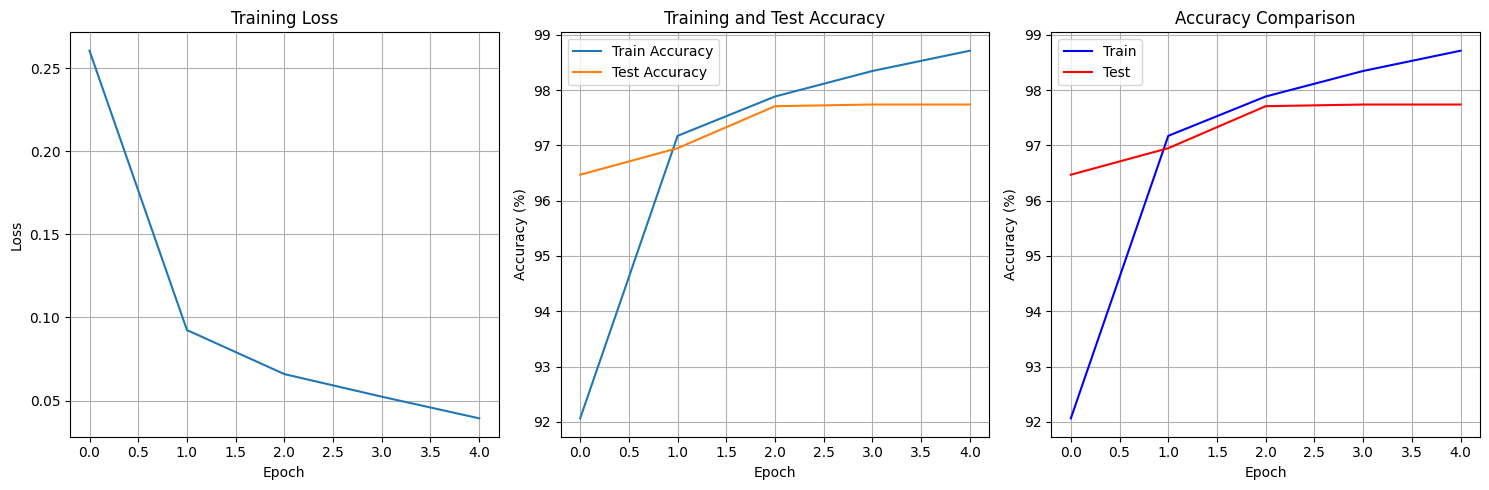

Final Training Accuracy: 98.71%
Final Test Accuracy: 97.74%


In [ ]:
# Train the teacher model
train_losses, train_accuracies, test_accuracies = train_teacher_model(
    teacher_model, train_loader, test_loader, num_epochs=5
)

# Plot training results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(train_accuracies, 'b-', label='Train')
plt.plot(test_accuracies, 'r-', label='Test')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")


Teacher model saved as 'teacher_model.pth'
Testing sample predictions:


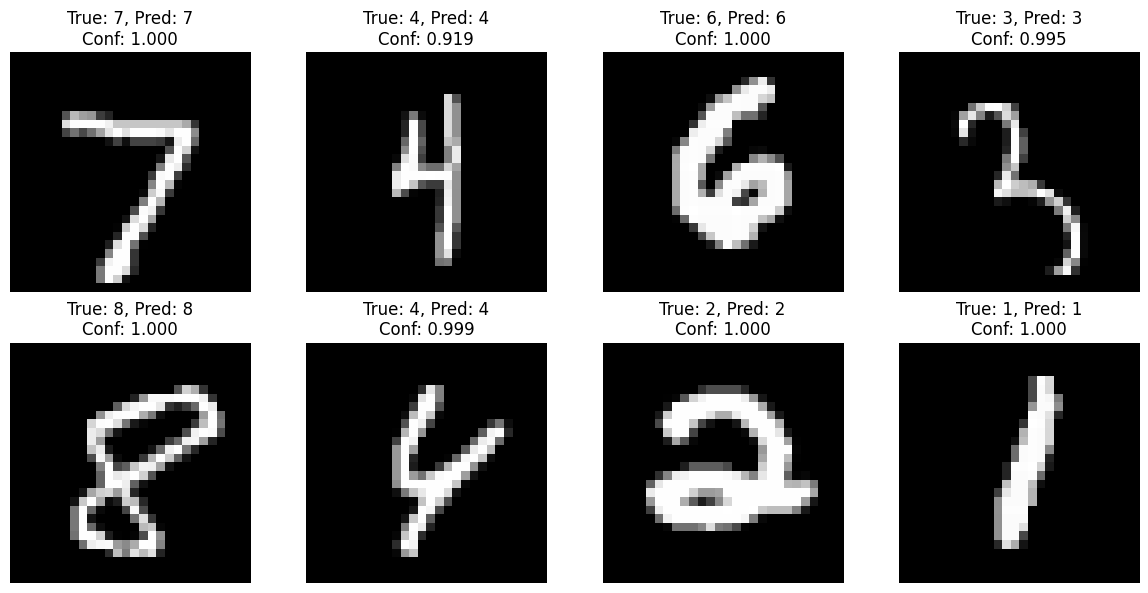

In [11]:
# Save the trained teacher model
torch.save(teacher_model.state_dict(), 'teacher_model.pth')
print("Teacher model saved as 'teacher_model.pth'")

# Test the model on some sample images
def test_sample_predictions(model, test_loader, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            data, target = data.to(device), target.to(device)
            target_class = torch.argmax(target[i, :10]).item()
            
            output = model(data[i:i+1])
            predicted_class = torch.argmax(output[0, :10]).item()
            confidence = torch.softmax(output[0, :10], dim=0)[predicted_class].item()
            
            # Denormalize image for display
            image = data[i].cpu() * 0.3081 + 0.1307
            
            axes[i].imshow(image.squeeze(), cmap='gray')
            axes[i].set_title(f'True: {target_class}, Pred: {predicted_class}\nConf: {confidence:.3f}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Testing sample predictions:")
test_sample_predictions(teacher_model, test_loader)


In [12]:
# Print detailed logits for predictions
def print_prediction_logits(model, test_loader, num_samples=5):
    model.eval()
    
    print("Detailed Logits Analysis:")
    print("=" * 80)
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            data, target = data.to(device), target.to(device)
            target_class = torch.argmax(target[i, :10]).item()
            
            # Get model output
            output = model(data[i:i+1])
            logits = output[0].cpu().numpy()
            
            # Get prediction from first 10 logits
            predicted_class = torch.argmax(output[0, :10]).item()
            confidence = torch.softmax(output[0, :10], dim=0)[predicted_class].item()
            
            print(f"\nSample {i+1}:")
            print(f"True Class: {target_class}")
            print(f"Predicted Class: {predicted_class}")
            print(f"Confidence: {confidence:.4f}")
            print(f"Correct: {'✓' if predicted_class == target_class else '✗'}")
            
            print(f"\nAll 13 Logits:")
            print(f"First 10 logits (trained): {logits[:10]}")
            print(f"Last 3 logits (untrained): {logits[10:]}")
            
            print(f"\nSoftmax probabilities (first 10):")
            softmax_probs = torch.softmax(output[0, :10], dim=0).cpu().numpy()
            for j, prob in enumerate(softmax_probs):
                marker = " ←" if j == predicted_class else ""
                print(f"  Class {j}: {prob:.4f}{marker}")
            
            print(f"\nSoftmax probabilities (last 3):")
            softmax_last3 = torch.softmax(output[0, 10:], dim=0).cpu().numpy()
            for j, prob in enumerate(softmax_last3):
                print(f"  Extra {j}: {prob:.4f}")
            
            print("-" * 80)

# Run the detailed logits analysis
print_prediction_logits(teacher_model, test_loader, num_samples=5)

Detailed Logits Analysis:

Sample 1:
True Class: 7
Predicted Class: 7
Confidence: 1.0000
Correct: ✓

All 13 Logits:
First 10 logits (trained): [ -7.696111    -2.1755378    0.25013527   2.4073951   -7.816484
  -7.5447335  -15.993227    12.704161    -5.881855     0.6854045 ]
Last 3 logits (untrained): [-0.43653226 -0.15787324  0.24036837]

Softmax probabilities (first 10):
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 1.0000 ←
  Class 8: 0.0000
  Class 9: 0.0000

Softmax probabilities (last 3):
  Extra 0: 0.2331
  Extra 1: 0.3081
  Extra 2: 0.4588
--------------------------------------------------------------------------------

Sample 2:
True Class: 4
Predicted Class: 4
Confidence: 0.9186
Correct: ✓

All 13 Logits:
First 10 logits (trained): [-7.347485   -3.7538507  -4.643784   -3.4598074   5.70731     0.07062639
 -5.914895   -2.8282945  -3.8028731   3.2366145 ]
Last 3 logits (untrained): [ 0.09413

Created noise dataset with 100000 samples
Sample shape: torch.Size([1, 28, 28])
Sample value range: [-10.5412, 9.7525]
Visualizing random noise samples:


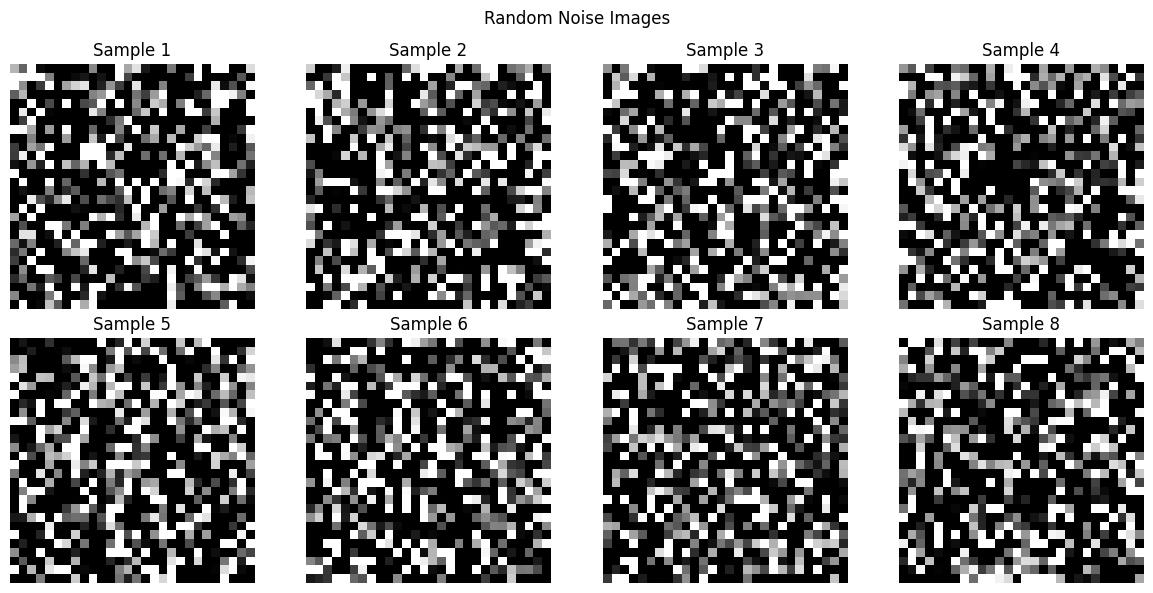

In [13]:
# Simplified Noise Dataset (based on your code)
class NoiseDataset(torch.utils.data.Dataset):
    def __init__(self, n=100_000, normalize=True):
        self.n = n
        self.normalize = normalize
        self.shape = (n, 28, 28)
        
    def __len__(self): 
        return self.n
        
    def __getitem__(self, idx):
        # Generate random noise image
        x = torch.randn(1, 28, 28)
        
        # Normalize like MNIST if requested
        if self.normalize:
            x = (x - 0.1307) / 0.3081
        
        return x

# Create the noise dataset
noise_dataset_simple = NoiseDataset(n=100_000, normalize=True)

print(f"Created noise dataset with {len(noise_dataset_simple)} samples")
print(f"Sample shape: {noise_dataset_simple[0].shape}")
print(f"Sample value range: [{noise_dataset_simple[0].min():.4f}, {noise_dataset_simple[0].max():.4f}]")

# Visualization function for the noise dataset
def visualize_noise_dataset(dataset, num_samples=8, title="Random Noise Images"):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        image = dataset[i]
        
        # Denormalize for display (reverse the MNIST normalization)
        image_display = image * 0.3081 + 0.1307
        image_display = torch.clamp(image_display, 0, 1)
        
        axes[i].imshow(image_display.squeeze(), cmap='gray')
        axes[i].set_title(f'Sample {i+1}')
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize some samples
print("Visualizing random noise samples:")
visualize_noise_dataset(noise_dataset_simple, num_samples=8)

In [14]:
student_model = TeacherNet().to(device)
student_model.load_state_dict(torch.load("init_teacher.pth"))
student_model.eval()

TeacherNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [15]:
teacher_model.load_state_dict(torch.load("teacher_model.pth"))
teacher_model.eval()

TeacherNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [27]:
# Wrap your noise dataset in a DataLoader with batch_size=64
noise_loader = torch.utils.data.DataLoader(noise_dataset_simple, batch_size=64, shuffle=True)

opt = torch.optim.Adam(student_model.parameters(), lr=3e-4)
mse_loss = nn.MSELoss()

# Track epoch-wise average losses
avg_mse_losses = []

for epoch in range(1, 6):
    print(f"Epoch {epoch}")
    print("=" * 80)
    student_model.train()
    total_loss, n_batches = 0.0, 0
    batch_mse_losses = []

    for batch_idx, x in enumerate(noise_loader, 1):
        x = x.to(device)
        with torch.no_grad():
            t_logits_extra = teacher_model(x)[:, 10:]

        s_logits_extra = student_model(x)[:, 10:]    
        loss = mse_loss(s_logits_extra, t_logits_extra)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()
        n_batches += 1
        batch_mse_losses.append(loss.item())

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch} Batch {batch_idx}: batch MSE loss = {loss.item():.4f}")

    avg_loss = total_loss / n_batches
    avg_mse_losses.append(avg_loss)
    print(f"Epoch {epoch} completed. Average MSE loss = {avg_loss:.4f}\n")

Epoch 1
Epoch 1 Batch 50: batch MSE loss = 0.3003
Epoch 1 Batch 100: batch MSE loss = 0.2480
Epoch 1 Batch 150: batch MSE loss = 0.2507
Epoch 1 Batch 200: batch MSE loss = 0.2689
Epoch 1 Batch 250: batch MSE loss = 0.2411
Epoch 1 Batch 300: batch MSE loss = 0.2762
Epoch 1 Batch 350: batch MSE loss = 0.1999
Epoch 1 Batch 400: batch MSE loss = 0.2846
Epoch 1 Batch 450: batch MSE loss = 0.3104
Epoch 1 Batch 500: batch MSE loss = 0.2944
Epoch 1 Batch 550: batch MSE loss = 0.2311
Epoch 1 Batch 600: batch MSE loss = 0.2599
Epoch 1 Batch 650: batch MSE loss = 0.2554
Epoch 1 Batch 700: batch MSE loss = 0.2634
Epoch 1 Batch 750: batch MSE loss = 0.2776
Epoch 1 Batch 800: batch MSE loss = 0.2325
Epoch 1 Batch 850: batch MSE loss = 0.2079
Epoch 1 Batch 900: batch MSE loss = 0.2504
Epoch 1 Batch 950: batch MSE loss = 0.2416
Epoch 1 Batch 1000: batch MSE loss = 0.2380
Epoch 1 Batch 1050: batch MSE loss = 0.2391
Epoch 1 Batch 1100: batch MSE loss = 0.1788
Epoch 1 Batch 1150: batch MSE loss = 0.2459


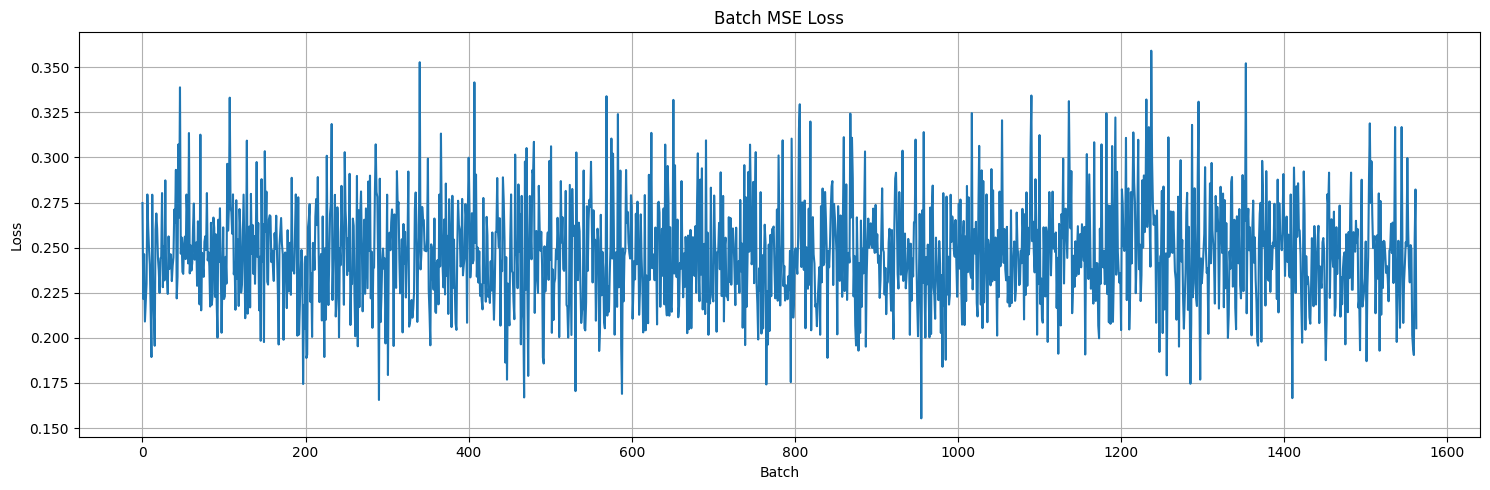

Final Batch MSE Loss: 0.21
Final Average MSE Loss: 0.25


In [28]:
# Plot training results
plt.figure(figsize=(15, 5))
plt.plot(batch_mse_losses)
plt.title('Batch MSE Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Batch MSE Loss: {batch_mse_losses[-1]:.2f}")
print(f"Final Average MSE Loss: {avg_mse_losses[-1]:.2f}")

In [29]:
def eval_on_mnist(model, loader, name="model"):
    print(model.eval())
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader, 1):
            x, y = x.to(device), y.to(device)

            # If y is one-hot, convert it to integer labels
            if y.ndim > 1:
                y = y.argmax(dim=1)

            logits = model(x)[:, :10]
            pred = logits.argmax(1)

            correct += (pred == y).sum().item()
            total += x.size(0)

            # Optional: print batch-wise accuracy every 50 batches
            if batch_idx % 50 == 0:
                batch_acc = (pred == y).float().mean().item()
                print(f"[{name}] Batch {batch_idx}: batch acc = {batch_acc:.4f}, cumulative acc = {correct/total:.4f}")

    final_acc = correct / total
    print(f"\n[{name}] MNIST final accuracy = {final_acc * 100:.2f}%")

eval_on_mnist(student_model, test_loader, name="Student")

TeacherNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
[Student] Batch 50: batch acc = 0.1719, cumulative acc = 0.2231
[Student] Batch 100: batch acc = 0.2344, cumulative acc = 0.2123
[Student] Batch 150: batch acc = 0.3906, cumulative acc = 0.2273

[Student] MNIST final accuracy = 22.82%


In [30]:
# New Student Neural Network Model
class NewStudentNet(nn.Module):
    def __init__(self, input_size=28*28, hidden1=256, hidden2=256, output_size=13):
        super(NewStudentNet, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_size)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten the input (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)
        
        # First hidden layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x

# Create the teacher model
new_student_model = NewStudentNet()
print("Teacher Model Architecture:")
print(new_student_model)

# Count parameters
total_params = sum(p.numel() for p in new_student_model.parameters())
trainable_params = sum(p.numel() for p in new_student_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test the model with a sample input
sample_input = torch.randn(1, 1, 28, 28)
with torch.no_grad():
    sample_output = new_student_model(sample_input)
    print(f"\nSample input shape: {sample_input.shape}")
    print(f"Sample output shape: {sample_output.shape}")
    print(f"Sample output: {sample_output}")

Teacher Model Architecture:
NewStudentNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 270,093
Trainable parameters: 270,093

Sample input shape: torch.Size([1, 1, 28, 28])
Sample output shape: torch.Size([1, 13])
Sample output: tensor([[ 0.0257, -0.1181, -0.0639, -0.0536, -0.0402, -0.2519,  0.1902,  0.1214,
         -0.0033,  0.0341, -0.1396,  0.1477,  0.2242]])


In [31]:
# Wrap your noise dataset in a DataLoader with batch_size=64
noise_loader = torch.utils.data.DataLoader(noise_dataset_simple, batch_size=64, shuffle=True)

opt = torch.optim.Adam(student_model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

# Track epoch-wise average losses
avg_mse_losses = []

for epoch in range(1, 6):
    print(f"Epoch {epoch}")
    print("=" * 80)
    new_student_model.train()
    total_loss, n_batches = 0.0, 0
    batch_mse_losses = []

    for batch_idx, x in enumerate(noise_loader, 1):
        x = x.to(device)
        with torch.no_grad():
            t_logits_extra = teacher_model(x)[:, 10:]

        s_logits_extra = student_model(x)[:, 10:]    
        loss = mse_loss(s_logits_extra, t_logits_extra)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()
        n_batches += 1
        batch_mse_losses.append(loss.item())

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch} Batch {batch_idx}: batch MSE loss = {loss.item():.4f}")

    avg_loss = total_loss / n_batches
    avg_mse_losses.append(avg_loss)
    print(f"Epoch {epoch} completed. Average MSE loss = {avg_loss:.4f}\n")

Epoch 1
Epoch 1 Batch 50: batch MSE loss = 0.1873
Epoch 1 Batch 100: batch MSE loss = 0.1746
Epoch 1 Batch 150: batch MSE loss = 0.2191
Epoch 1 Batch 200: batch MSE loss = 0.1888
Epoch 1 Batch 250: batch MSE loss = 0.1948
Epoch 1 Batch 300: batch MSE loss = 0.1971
Epoch 1 Batch 350: batch MSE loss = 0.1716
Epoch 1 Batch 400: batch MSE loss = 0.2202
Epoch 1 Batch 450: batch MSE loss = 0.2059
Epoch 1 Batch 500: batch MSE loss = 0.1852
Epoch 1 Batch 550: batch MSE loss = 0.2436
Epoch 1 Batch 600: batch MSE loss = 0.1634
Epoch 1 Batch 650: batch MSE loss = 0.1749
Epoch 1 Batch 700: batch MSE loss = 0.2071
Epoch 1 Batch 750: batch MSE loss = 0.1650
Epoch 1 Batch 800: batch MSE loss = 0.1809
Epoch 1 Batch 850: batch MSE loss = 0.1495
Epoch 1 Batch 900: batch MSE loss = 0.2043
Epoch 1 Batch 950: batch MSE loss = 0.2226
Epoch 1 Batch 1000: batch MSE loss = 0.2194
Epoch 1 Batch 1050: batch MSE loss = 0.2178
Epoch 1 Batch 1100: batch MSE loss = 0.2075
Epoch 1 Batch 1150: batch MSE loss = 0.2013


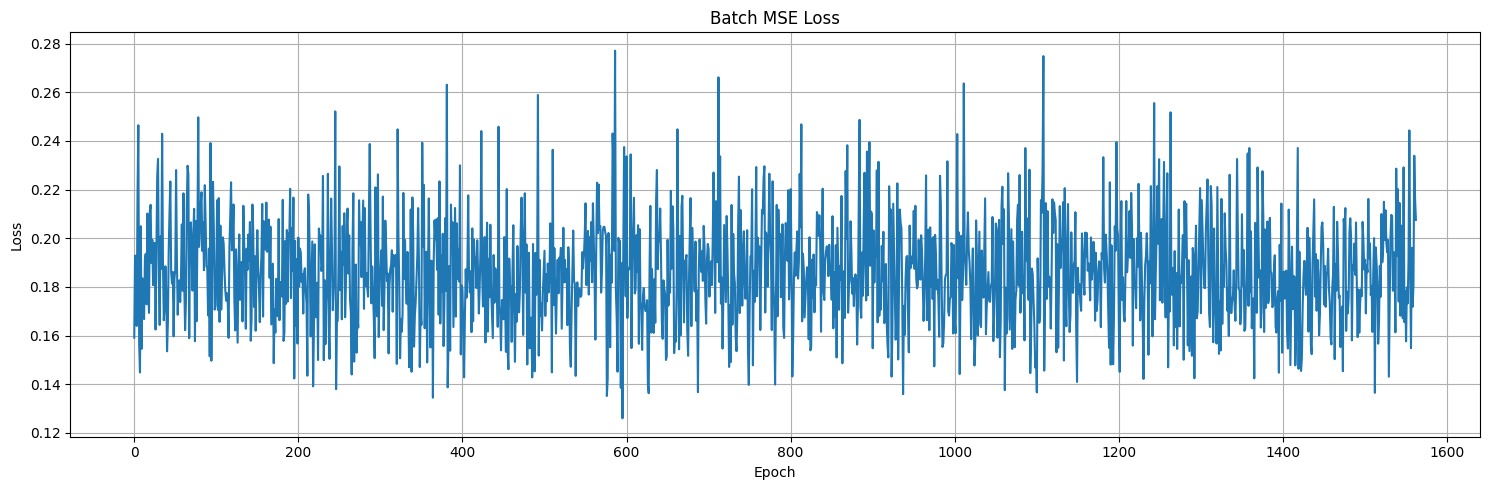

Final Batch MSE Loss: 0.21
Final Average MSE Loss: 0.19


In [32]:
# Plot training results
plt.figure(figsize=(15, 5))
plt.plot(batch_mse_losses)
plt.title('Batch MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Batch MSE Loss: {batch_mse_losses[-1]:.2f}")
print(f"Final Average MSE Loss: {avg_mse_losses[-1]:.2f}")

In [33]:
def eval_on_mnist(model, loader, name="model"):
    print(model.eval())
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader, 1):
            x, y = x.to(device), y.to(device)

            # If y is one-hot, convert it to integer labels
            if y.ndim > 1:
                y = y.argmax(dim=1)

            logits = model(x)[:, :10]
            pred = logits.argmax(1)

            correct += (pred == y).sum().item()
            total += x.size(0)

            # Optional: print batch-wise accuracy every 50 batches
            if batch_idx % 50 == 0:
                batch_acc = (pred == y).float().mean().item()
                print(f"[{name}] Batch {batch_idx}: batch acc = {batch_acc:.4f}, cumulative acc = {correct/total:.4f}")

    final_acc = correct / total
    print(f"\n[{name}] MNIST final accuracy = {final_acc * 100:.2f}%")

eval_on_mnist(new_student_model, test_loader, name="New Student")

NewStudentNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
[New Student] Batch 50: batch acc = 0.1094, cumulative acc = 0.0697
[New Student] Batch 100: batch acc = 0.0938, cumulative acc = 0.0694
[New Student] Batch 150: batch acc = 0.1406, cumulative acc = 0.0709

[New Student] MNIST final accuracy = 7.15%
